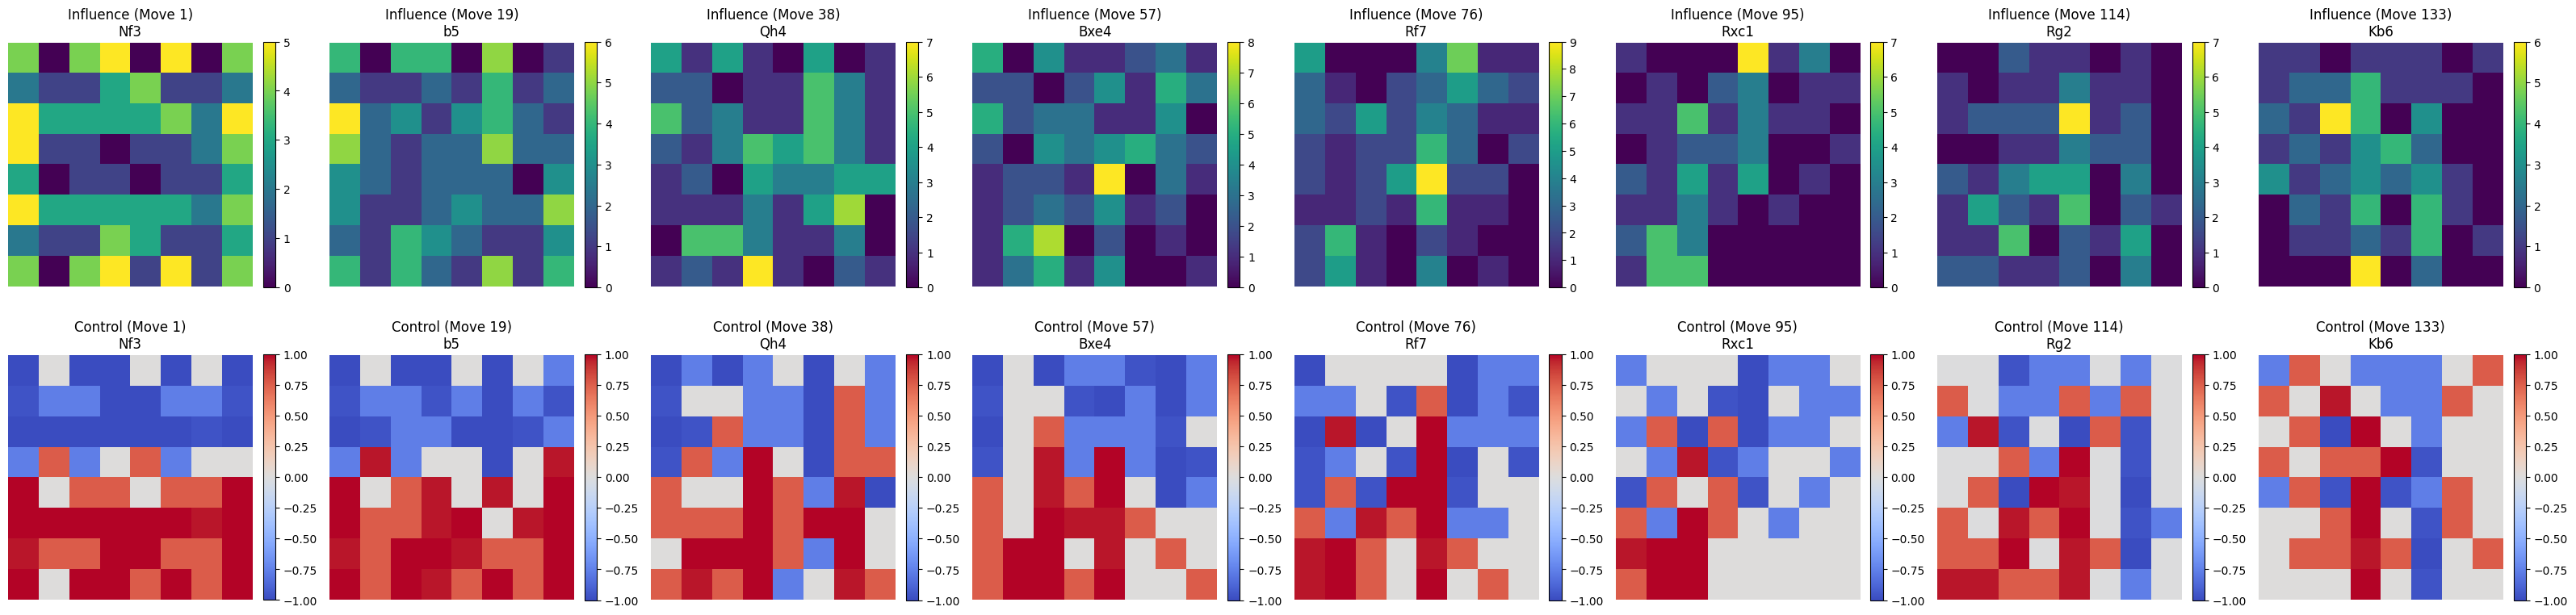

Final Total Influence:
[[1. 1. 0. 1. 1. 1. 0. 1.]
 [1. 2. 2. 4. 1. 1. 1. 0.]
 [2. 1. 6. 4. 0. 3. 0. 0.]
 [1. 2. 1. 3. 4. 2. 0. 0.]
 [3. 1. 2. 3. 2. 3. 1. 0.]
 [0. 2. 1. 4. 0. 4. 1. 0.]
 [0. 1. 1. 2. 1. 4. 0. 1.]
 [0. 0. 0. 6. 0. 2. 0. 0.]]

Final Board Control (positive for white, negative for black):
[[-0.7615942  0.7615942  0.        -0.7615942 -0.7615942 -0.7615942
   0.         0.7615942]
 [ 0.7615942  0.         0.9640276  0.        -0.7615942 -0.7615942
   0.7615942  0.       ]
 [ 0.         0.7615942 -0.9993293  0.9993293  0.        -0.7615942
   0.         0.       ]
 [ 0.7615942  0.         0.7615942  0.7615942  0.9993293 -0.9640276
   0.         0.       ]
 [-0.7615942  0.7615942 -0.9640276  0.9950548 -0.9640276 -0.7615942
   0.7615942  0.       ]
 [ 0.         0.         0.7615942  0.9993293  0.        -0.9640276
   0.7615942  0.       ]
 [ 0.         0.7615942  0.7615942  0.9640276  0.7615942 -0.9993293
   0.         0.7615942]
 [ 0.         0.         0.         0.9999877 

In [22]:
import torch
import chess
import chess.svg
import numpy as np
import matplotlib.pyplot as plt
from cairosvg import svg2png
from PIL import Image
import io

def board_to_tensor(board):
    piece_to_index = {
        'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
        'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
    }
    tensor = torch.zeros(12, 8, 8)
    for square, piece in board.piece_map().items():
        rank, file = divmod(square, 8)
        tensor[piece_to_index[piece.symbol()]][7-rank][file] = 1
    return tensor

def create_influence_channels(board_tensor):
    influence_channels = torch.zeros(12, 8, 8)
    
    # Pawn influences
    white_pawn = board_tensor[0]
    black_pawn = board_tensor[6]
    influence_channels[0, :-1, 1:] += white_pawn[1:, :-1]  # Diagonal right
    influence_channels[0, :-1, :-1] += white_pawn[1:, 1:]  # Diagonal left
    influence_channels[6, 1:, 1:] += black_pawn[:-1, :-1]  # Diagonal right
    influence_channels[6, 1:, :-1] += black_pawn[:-1, 1:]  # Diagonal left
    
    # Knight influences
    knight_kernel = torch.tensor([
        [0,1,0,1,0],
        [1,0,0,0,1],
        [0,0,0,0,0],
        [1,0,0,0,1],
        [0,1,0,1,0]
    ]).float()
    influence_channels[1] = torch.nn.functional.conv2d(board_tensor[1].unsqueeze(0).unsqueeze(0), knight_kernel.unsqueeze(0).unsqueeze(0), padding=2)[0, 0]
    influence_channels[7] = torch.nn.functional.conv2d(board_tensor[7].unsqueeze(0).unsqueeze(0), knight_kernel.unsqueeze(0).unsqueeze(0), padding=2)[0, 0]
    
    # Sliding piece influences (Bishop, Rook, Queen)
    for i, directions in enumerate([(1,1), (1,0), (1,1)]):  # Bishop, Rook, Queen
        white_influence = torch.zeros(8, 8)
        black_influence = torch.zeros(8, 8)
        for dx, dy in [directions, (-directions[0], directions[1]), (directions[0], -directions[1]), (-directions[0], -directions[1])]:
            ray = torch.zeros(8, 8)
            x, y = 3, 3
            while 0 <= x < 8 and 0 <= y < 8:
                ray[x, y] = 1
                x, y = x + dx, y + dy
            white_influence += torch.nn.functional.conv2d(board_tensor[i+2].unsqueeze(0).unsqueeze(0), ray.unsqueeze(0).unsqueeze(0), padding='same')[0, 0]
            black_influence += torch.nn.functional.conv2d(board_tensor[i+8].unsqueeze(0).unsqueeze(0), ray.unsqueeze(0).unsqueeze(0), padding='same')[0, 0]
        influence_channels[i+2] = white_influence
        influence_channels[i+8] = black_influence
    
    # King influences
    king_kernel = torch.tensor([
        [1,1,1],
        [1,0,1],
        [1,1,1]
    ]).float()
    influence_channels[5] = torch.nn.functional.conv2d(board_tensor[5].unsqueeze(0).unsqueeze(0), king_kernel.unsqueeze(0).unsqueeze(0), padding=1)[0, 0]
    influence_channels[11] = torch.nn.functional.conv2d(board_tensor[11].unsqueeze(0).unsqueeze(0), king_kernel.unsqueeze(0).unsqueeze(0), padding=1)[0, 0]
    
    return influence_channels

def combine_influences(influence_channels):
    white_influence = influence_channels[:6].sum(dim=0)
    black_influence = influence_channels[6:].sum(dim=0)
    
    # Calculate total influence and control
    total_influence = white_influence + black_influence
    control = torch.tanh(white_influence - black_influence)
    
    return total_influence, control

def create_jepa_mask(influence_map, mask_ratio=0.25):
    num_squares = influence_map.numel()
    num_masked = int(num_squares * mask_ratio)
    _, indices = torch.topk(influence_map.flatten(), k=num_masked)
    mask = torch.ones_like(influence_map, dtype=torch.bool)
    mask.view(-1)[indices] = False
    return mask

def board_to_image(board):
    svg = chess.svg.board(board=board, size=400)
    png = svg2png(bytestring=svg)
    return Image.open(io.BytesIO(png))

def plot_board_with_overlay(ax, board_image, overlay_data, title, cmap='coolwarm'):
    ax.imshow(board_image)
    overlay = ax.imshow(overlay_data, cmap=cmap, alpha=0.6, vmin=-1, vmax=1)
    ax.set_title(title)
    ax.axis('off')
    return overlay

# # Set up the chess game
# board = chess.Board()
# moves = [
#     "d4", "Nf6", "c4", "e6", "Nc3", "Bb4", "e3", "O-O", "Bd3", "d5", "Nf3", "c5", "O-O", "cxd4", "exd4", "dxc4",
#     "Bxc4", "b6", "Bg5", "Bb7", "Re1", "Nbd7", "Rc1", "Rc8", "Qb3", "Be7", "Bxf6", "Nxf6", "Bxe6", "fxe6",
#     "Qxe6+", "Kh8", "Qxe7", "Bxf3", "gxf3", "Qxd4", "Nb5", "Qxb2", "Rxc8", "Rxc8", "Nd6", "Rb8", "Nf7+", "Kg8",
#     "Qe6", "Rf8", "Nd8+", "Kh8", "Qe7"
# ]

# for move in moves:
#     board.push_san(move)

# # Create board tensor and influence channels
# board_tensor = board_to_tensor(board)
# influence_channels = create_influence_channels(board_tensor)

# # Combine influences
# total_influence, control = combine_influences(influence_channels)

# # Create JEPA-like mask
# jepa_mask = create_jepa_mask(total_influence)

# # Visualize the results
# fig, axs = plt.subplots(1, 4, figsize=(25, 6))

# board_image = np.array(board_to_image(board))

# axs[0].imshow(board_image)
# axs[0].set_title("Chess Board")
# axs[0].axis('off')

# influence_overlay = plot_board_with_overlay(axs[1], board_image, total_influence.numpy(), "Total Influence", cmap='viridis')
# control_overlay = plot_board_with_overlay(axs[2], board_image, control.numpy(), "Board Control")
# mask_overlay = plot_board_with_overlay(axs[3], board_image, ~jepa_mask.numpy(), "JEPA-like Mask", cmap='binary')

# plt.colorbar(influence_overlay, ax=axs[1], fraction=0.046, pad=0.04)
# plt.colorbar(control_overlay, ax=axs[2], fraction=0.046, pad=0.04)
# plt.colorbar(mask_overlay, ax=axs[3], fraction=0.046, pad=0.04)

# plt.tight_layout()
# plt.show()

# print("Total Influence:")
# print(total_influence.numpy())
# print("\nBoard Control (positive for white, negative for black):")
# print(control.numpy())
# print("\nJEPA-like mask (True = masked, False = visible):")
# print(jepa_mask.numpy())
def analyze_game_sequence(moves):
    board = chess.Board()
    influence_history = []
    control_history = []

    for move in moves:
        board.push_san(move)
        board_tensor = board_to_tensor(board)
        influence_channels = create_influence_channels(board_tensor)
        total_influence, control = combine_influences(influence_channels)
        influence_history.append(total_influence.numpy())
        control_history.append(control.numpy())

    return influence_history, control_history

def plot_game_progression(influence_history, control_history, moves, num_positions=8):
    num_moves = len(influence_history)
    positions_to_show = np.linspace(0, num_moves - 1, num_positions, dtype=int)

    fig, axs = plt.subplots(2, num_positions, figsize=(4 * num_positions, 8))

    for i, move_index in enumerate(positions_to_show):
        influence = influence_history[move_index]
        control = control_history[move_index]

        im1 = axs[0, i].imshow(influence, cmap='viridis')
        axs[0, i].set_title(f"Influence (Move {move_index + 1})\n{moves[move_index]}")
        axs[0, i].axis('off')
        plt.colorbar(im1, ax=axs[0, i], fraction=0.046, pad=0.04)

        im2 = axs[1, i].imshow(control, cmap='coolwarm', vmin=-1, vmax=1)
        axs[1, i].set_title(f"Control (Move {move_index + 1})\n{moves[move_index]}")
        axs[1, i].axis('off')
        plt.colorbar(im2, ax=axs[1, i], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# # vladimir borisovich's win
# moves = [
#     "d4", "Nf6", "c4", "e6", "Nc3", "Bb4", "e3", "O-O", "Bd3", "d5", "Nf3", "c5", "O-O", "cxd4", "exd4", "dxc4",
#     "Bxc4", "b6", "Bg5", "Bb7", "Re1", "Nbd7", "Rc1", "Rc8", "Qb3", "Be7", "Bxf6", "Nxf6", "Bxe6", "fxe6",
#     "Qxe6+", "Kh8", "Qxe7", "Bxf3", "gxf3", "Qxd4", "Nb5", "Qxb2", "Rxc8", "Rxc8", "Nd6", "Rb8", "Nf7+", "Kg8",
#     "Qe6", "Rf8", "Nd8+", "Kh8", "Qe7"
# ]

# # Analyze the game sequence
# influence_history, control_history = analyze_game_sequence(moves)

# # Plot the game progression
# plot_game_progression(influence_history, control_history)

# # Print final influence and control
# print("Final Total Influence:")
# print(influence_history[-1])
# print("\nFinal Board Control (positive for white, negative for black):")
# print(control_history[-1])

# AlphaZero's Immortal game
# moves = [
#     "Nf3", "Nf6", "c4", "e6", "Nc3", "Bb4", "Qc2", "O-O", "a3", "Bxc3", "Qxc3", "a5", "b4", "d6", "e3", "Ne4", 
#     "Qc2", "Ng5", "b5", "Nxf3+", "gxf3", "Qf6", "d4", "Qxf3", "Rg1", "Nd7", "Be2", "Qf6", "Bb2", "Qh4", "Rg4", 
#     "Qxh2", "Rg3", "f5", "O-O-O", "Rf7", "Bf3", "Qh4", "Rh1", "Qf6", "Kb1", "g6", "Rgg1", "a4", "Ka1", "Rg7", 
#     "e4", "f4", "c5", "Qe7", "Rc1", "Nf6", "e5", "dxe5", "Rhe1", "e4", "Bxe4", "Qf8", "d5", "exd5", "Bd3", 
#     "Bg4", "f3", "Bd7", "Qc3", "Nh5", "Re5", "c6", "Rce1", "Nf6", "Qd4", "cxb5", "Bb1", "Bc6", "Re6", "Rf7", 
#     "Rg1", "Qg7", "Qxf4", "Re8", "Rd6", "Nd7", "Qc1", "Rf6", "f4", "Qe7", "Rxf6", "Nxf6", "f5", "Qe3", "fxg6", 
#     "Qxc1", "gxh7+", "Kf7", "Rxc1", "Nxh7", "Bxh7", "Re3", "Rd1", "Ke8", "Ka2", "Bd7", "Bd4", "Rh3", "Bc2", 
#     "Be6", "Re1", "Kd7", "Kb2", "Rf3", "Re5", "Rg3", "Re3", "Rg2", "Kc3", "Rg4", "Rf3", "Ke8", "Rf2", "Rg3+", 
#     "Kb4", "Rg4", "Rd2", "Bd7", "Ka5", "Rf4", "Be5", "Rf3", "Rd3", "Rf2", "Bd1", "Bc6", "Kb6"
# ]

# # Analyze the game sequence
# influence_history, control_history = analyze_game_sequence(moves)

# # Plot the game progression
# plot_game_progression(influence_history, control_history, moves)

# # Print final influence and control
# print("Final Total Influence:")
# print(influence_history[-1])
# print("\nFinal Board Control (positive for white, negative for black):")
# print(control_history[-1])

def analyze_game_sequence(moves):
    board = chess.Board()
    influence_history = []
    control_history = []
    influence_shifts = []
    control_shifts = []

    for move in moves:
        board.push_san(move)
        board_tensor = board_to_tensor(board)
        influence_channels = create_influence_channels(board_tensor)
        total_influence, control = combine_influences(influence_channels)
        
        influence_history.append(total_influence.numpy())
        control_history.append(control.numpy())
        
        if len(influence_history) > 1:
            influence_shift = np.sum(np.abs(influence_history[-1] - influence_history[-2]))
            control_shift = np.sum(np.abs(control_history[-1] - control_history[-2]))
            influence_shifts.append(influence_shift)
            control_shifts.append(control_shift)

    return influence_history, control_history, influence_shifts, control_shifts

def plot_game_stats(moves, influence_shifts, control_shifts):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 1, 1)
    plt.plot(influence_shifts, label='Influence Shift')
    plt.title('Influence Shifts Throughout the Game')
    plt.xlabel('Move Number')
    plt.ylabel('Total Absolute Change')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(control_shifts, label='Control Shift', color='orange')
    plt.title('Control Shifts Throughout the Game')
    plt.xlabel('Move Number')
    plt.ylabel('Total Absolute Change')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def identify_key_moves(moves, influence_shifts, control_shifts, top_n=5):
    combined_shifts = np.array(influence_shifts) + np.array(control_shifts)
    top_indices = combined_shifts.argsort()[-top_n:][::-1]
    
    print(f"Top {top_n} Most Impactful Moves:")
    for i, idx in enumerate(top_indices, 1):
        print(f"{i}. Move {idx+1}: {moves[idx]} (Influence Shift: {influence_shifts[idx]:.2f}, Control Shift: {control_shifts[idx]:.2f})")

def calculate_game_stats(influence_history, control_history):
    influence_array = np.array(influence_history)
    control_array = np.array(control_history)
    
    avg_influence = np.mean(influence_array, axis=0)
    avg_control = np.mean(control_array, axis=0)
    
    white_advantage = np.sum(control_array > 0, axis=1) / 64  # Percentage of squares controlled by white
    black_advantage = np.sum(control_array < 0, axis=1) / 64  # Percentage of squares controlled by black
    
    print("\nGame Statistics:")
    print(f"Average Total Influence:\n{avg_influence}")
    print(f"\nAverage Control (positive for white, negative for black):\n{avg_control}")
    print(f"\nWhite's average board control: {np.mean(white_advantage):.2%}")
    print(f"Black's average board control: {np.mean(black_advantage):.2%}")
    print(f"\nLargest white advantage: {np.max(white_advantage):.2%} (Move {np.argmax(white_advantage)+1})")
    print(f"Largest black advantage: {np.max(black_advantage):.2%} (Move {np.argmax(black_advantage)+1})")

# AlphaZero's Immortal game moves
moves = [
    "Nf3", "Nf6", "c4", "e6", "Nc3", "Bb4", "Qc2", "O-O", "a3", "Bxc3", "Qxc3", "a5", "b4", "d6", "e3", "Ne4", 
    "Qc2", "Ng5", "b5", "Nxf3+", "gxf3", "Qf6", "d4", "Qxf3", "Rg1", "Nd7", "Be2", "Qf6", "Bb2", "Qh4", "Rg4", 
    "Qxh2", "Rg3", "f5", "O-O-O", "Rf7", "Bf3", "Qh4", "Rh1", "Qf6", "Kb1", "g6", "Rgg1", "a4", "Ka1", "Rg7", 
    "e4", "f4", "c5", "Qe7", "Rc1", "Nf6", "e5", "dxe5", "Rhe1", "e4", "Bxe4", "Qf8", "d5", "exd5", "Bd3", 
    "Bg4", "f3", "Bd7", "Qc3", "Nh5", "Re5", "c6", "Rce1", "Nf6", "Qd4", "cxb5", "Bb1", "Bc6", "Re6", "Rf7", 
    "Rg1", "Qg7", "Qxf4", "Re8", "Rd6", "Nd7", "Qc1", "Rf6", "f4", "Qe7", "Rxf6", "Nxf6", "f5", "Qe3", "fxg6", 
    "Qxc1", "gxh7+", "Kf7", "Rxc1", "Nxh7", "Bxh7", "Re3", "Rd1", "Ke8", "Ka2", "Bd7", "Bd4", "Rh3", "Bc2", 
    "Be6", "Re1", "Kd7", "Kb2", "Rf3", "Re5", "Rg3", "Re3", "Rg2", "Kc3", "Rg4", "Rf3", "Ke8", "Rf2", "Rg3+", 
    "Kb4", "Rg4", "Rd2", "Bd7", "Ka5", "Rf4", "Be5", "Rf3", "Rd3", "Rf2", "Bd1", "Bc6", "Kb6"
]

# Analyze the game sequence
influence_history, control_history, influence_shifts, control_shifts = analyze_game_sequence(moves)

# Plot game statistics
plot_game_stats(moves, influence_shifts, control_shifts)

# Identify key moves
identify_key_moves(moves, influence_shifts, control_shifts)

# Calculate and print game statistics
calculate_game_stats(influence_history, control_history)